In [1]:
"""
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
import pandas as pd
import re
import warnings
import random
import matplotlib
from tqdm.notebook import tqdm
from matplotlib.patches import Patch
from scipy.stats import linregress, spearmanr
import analysis_utils
from copy import deepcopy

# path to repository folder (data is stored here as well)
path = '..'
preds_loc = os.path.join(path, 'data', 'inference', 's669_mapped_preds_clusters.csv')

# default plotting settings
font = {'size'   : 18}
matplotlib.rc('font', **font)

# notebook display options
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 300

remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

db = pd.read_csv(preds_loc)
db['uid2'] = db['code'] + '_' + db['position'].astype(int).astype(str) + db['mutation'].str[-1]
db = db.set_index(['uid', 'uid2'])
db_runtimes = db[[col for col in db.columns if 'runtime' in col]]
db_runtimes['runtime_korpm'] = 0.0015
db
"""

"\nimport os\nimport pandas as pd\nimport numpy as np\nimport seaborn as sns\nfrom matplotlib import pyplot as plt\nfrom sklearn import metrics\nimport pandas as pd\nimport re\nimport warnings\nimport random\nimport matplotlib\nfrom tqdm.notebook import tqdm\nfrom matplotlib.patches import Patch\nfrom scipy.stats import linregress, spearmanr\nimport analysis_utils\nfrom copy import deepcopy\n\n# path to repository folder (data is stored here as well)\npath = '..'\npreds_loc = os.path.join(path, 'data', 'inference', 's669_mapped_preds_clusters.csv')\n\n# default plotting settings\nfont = {'size'   : 18}\nmatplotlib.rc('font', **font)\n\n# notebook display options\nwarnings.filterwarnings('ignore')\npd.options.display.max_rows = 300\n\nremap_names = analysis_utils.remap_names\nremap_names_2 = analysis_utils.remap_names_2\n\ndb = pd.read_csv(preds_loc)\ndb['uid2'] = db['code'] + '_' + db['position'].astype(int).astype(str) + db['mutation'].str[-1]\ndb = db.set_index(['uid', 'uid2'])\ndb_r

In [2]:
"""
# Get predictions from Rosetta (included in repo, NEED TO DOWNLOAD WITH GIT LFS AND UNZIP)
# assuming you have designated the repo location as the path
# the predictions are already included so only run this if you want to regenerate them

db_mod = db.copy(deep=True)
db = db.reset_index().rename({'uid': 'uid_'}, axis=1).rename({'uid2': 'uid'}, axis=1).set_index('uid')
# extract the runtimes for methods that have it (not currently used)
db_runtimes = db_runtimes.reset_index().rename({'uid': 'uid_'}, axis=1).rename({'uid2': 'uid'}, axis=1).set_index('uid')
print('getting cartesian predictions')
# assuming you have designated the repo location as the path
df_cart, df_cart_runtimes = analysis_utils.parse_rosetta_predictions(db, os.path.join(path, 'data', 'rosetta_predictions'), runtime=True)
try:
    db = db.join(df_cart.astype(float), how='left').reset_index().rename({'uid': 'uid2'}, axis=1).rename({'uid_': 'uid'}, axis=1).set_index(['uid', 'uid2'])
    db_runtimes = db_runtimes.join(df_cart_runtimes, how='left').reset_index().rename({'uid': 'uid2'}, axis=1).rename({'uid_': 'uid'}, axis=1).set_index(['uid', 'uid2'])
except ValueError:
    pass

db_mod = db_mod.reset_index().rename({'uid': 'uid_', 'uid2': 'uid'}, axis=1).set_index('uid').join(df_cart.astype(float), how='left')
db_mod = db_mod.join(df_cart_runtimes[['runtime_cartesian_ddg_dir']], how='left').reset_index().rename({'uid': 'uid2'}, axis=1).rename({'uid_': 'uid'}, axis=1).set_index(['uid', 'uid2'])
db_mod.to_csv(preds_loc)

# ~10 seconds on SSD, 5 minutes on HDD
"""

"\n# Get predictions from Rosetta (included in repo, NEED TO DOWNLOAD WITH GIT LFS AND UNZIP)\n# assuming you have designated the repo location as the path\n# the predictions are already included so only run this if you want to regenerate them\n\ndb_mod = db.copy(deep=True)\ndb = db.reset_index().rename({'uid': 'uid_'}, axis=1).rename({'uid2': 'uid'}, axis=1).set_index('uid')\n# extract the runtimes for methods that have it (not currently used)\ndb_runtimes = db_runtimes.reset_index().rename({'uid': 'uid_'}, axis=1).rename({'uid2': 'uid'}, axis=1).set_index('uid')\nprint('getting cartesian predictions')\n# assuming you have designated the repo location as the path\ndf_cart, df_cart_runtimes = analysis_utils.parse_rosetta_predictions(db, os.path.join(path, 'data', 'rosetta_predictions'), runtime=True)\ntry:\n    db = db.join(df_cart.astype(float), how='left').reset_index().rename({'uid': 'uid2'}, axis=1).rename({'uid_': 'uid'}, axis=1).set_index(['uid', 'uid2'])\n    db_runtimes = db_ru

In [3]:
"""
# create and use a third index for matching with the S461 subset
db_full = db.copy(deep=True)
db_full['uid3'] = db['code'] + '_' + db['PDB_Mut'].str[1:]
db_full = db_full.reset_index().set_index('uid3')

# preprocess S461 to align with S669
s461 = pd.read_csv(os.path.join(path, 'data', 'external_datasets', 'S461.csv'))
s461['uid3'] = s461['PDB'] + '_' + s461['MUT_D'].str[2:]
s461 = s461.set_index('uid3')
s461['ddG_I'] = -s461['ddG_D']
s461.columns = [s+'_dir' for s in s461.columns]
s461 = s461.rename({'ddG_D_dir': 'ddG_dir', 'ddG_I_dir': 'ddG_inv'}, axis=1)

# merge S669 with S461 (keeping predictions from both for comparison purposes)
db = s461.join(db_full.drop(['PDB_dir', 'MUT_D_dir', 'ddG_dir', 'KORPMD_dir', 'CartddgD_dir',
       'FoldXD_dir', 'EvoD_dir', 'Dyna2D_dir', 'PopMsD_dir', 'DDGunD_dir',
       'TNetD_dir', 'ACDCNND_dir', 'ddG_inv'], axis=1), how='left').reset_index(drop=True).set_index(['uid', 'uid2'])

# our Rosetta predictions are not that stronly correlated to Hernandez et. al, although ours tend to perform better
print(db[['CartddgD_dir', 'cartesian_ddg_dir']].corr().iloc[1,0])
"""

"\n# create and use a third index for matching with the S461 subset\ndb_full = db.copy(deep=True)\ndb_full['uid3'] = db['code'] + '_' + db['PDB_Mut'].str[1:]\ndb_full = db_full.reset_index().set_index('uid3')\n\n# preprocess S461 to align with S669\ns461 = pd.read_csv(os.path.join(path, 'data', 'external_datasets', 'S461.csv'))\ns461['uid3'] = s461['PDB'] + '_' + s461['MUT_D'].str[2:]\ns461 = s461.set_index('uid3')\ns461['ddG_I'] = -s461['ddG_D']\ns461.columns = [s+'_dir' for s in s461.columns]\ns461 = s461.rename({'ddG_D_dir': 'ddG_dir', 'ddG_I_dir': 'ddG_inv'}, axis=1)\n\n# merge S669 with S461 (keeping predictions from both for comparison purposes)\ndb = s461.join(db_full.drop(['PDB_dir', 'MUT_D_dir', 'ddG_dir', 'KORPMD_dir', 'CartddgD_dir',\n       'FoldXD_dir', 'EvoD_dir', 'Dyna2D_dir', 'PopMsD_dir', 'DDGunD_dir',\n       'TNetD_dir', 'ACDCNND_dir', 'ddG_inv'], axis=1), how='left').reset_index(drop=True).set_index(['uid', 'uid2'])\n\n# our Rosetta predictions are not that stronly 

In [4]:
"""
# reduced extraneous information
original_pred_cols = [c for c in db.columns if '_dir' in c and not 'runtime' in c and not 'pll' in c and not 'ddG' in c]
for col in ['PDB_dir', 'MUT_D_dir', 'SEC_STR_dir', 'SOL_ACC_dir']:
    original_pred_cols.remove(col)
original_pred_cols_reduced = deepcopy(original_pred_cols)
for col in [f'esm1v_{i}_dir' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)
for col in [f'msa_{i}_dir' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)

print(original_pred_cols_reduced)

# reduce the dataframe to only include immediately relevant information
cols = db.columns
drop = [col for col in db.columns if 'Unnamed' in col]
drop += [col for col in db.columns if 'pdb' in col]
drop += [col for col in db.columns if 'offset' in col]
db = db.drop(drop, axis=1)
db = db.drop(['PDB_dir', 'MUT_D_dir'], axis=1)

# extract predictions
cols = db.columns
incl = [col for col in db.columns if ('_dir' in col) or ('_inv' in col)]

db_preds = db[original_pred_cols]

# use the S461 labels as the ground truth labels
db_ddg = db[['ddG_dir']]
db_clusters = db[['cluster']]
"""

"\n# reduced extraneous information\noriginal_pred_cols = [c for c in db.columns if '_dir' in c and not 'runtime' in c and not 'pll' in c and not 'ddG' in c]\nfor col in ['PDB_dir', 'MUT_D_dir', 'SEC_STR_dir', 'SOL_ACC_dir']:\n    original_pred_cols.remove(col)\noriginal_pred_cols_reduced = deepcopy(original_pred_cols)\nfor col in [f'esm1v_{i}_dir' for i in range(1,6)]:\n    original_pred_cols_reduced.remove(col)\nfor col in [f'msa_{i}_dir' for i in range(1,6)]:\n    original_pred_cols_reduced.remove(col)\n\nprint(original_pred_cols_reduced)\n\n# reduce the dataframe to only include immediately relevant information\ncols = db.columns\ndrop = [col for col in db.columns if 'Unnamed' in col]\ndrop += [col for col in db.columns if 'pdb' in col]\ndrop += [col for col in db.columns if 'offset' in col]\ndb = db.drop(drop, axis=1)\ndb = db.drop(['PDB_dir', 'MUT_D_dir'], axis=1)\n\n# extract predictions\ncols = db.columns\nincl = [col for col in db.columns if ('_dir' in col) or ('_inv' in col)]

In [5]:
### At this point, you would run q3421_analysis.ipynb if you wanted to do a fresh recursive feature elimination (it uses the mapped_preds_clusters_extra.csv file)

In [6]:
"""
neff = pd.read_csv(os.path.join(path, 'data', 'features', 'neff_s669.csv'), header=None).set_index(0) # todo / fix
neff.index.name = 'code'
neff.columns = ['neff']

db_feats_2 = pd.read_csv(os.path.join(path, 'data', 'features', 's669_local_mapped_feats.csv'))
db_feats_2['uid'] = db_feats_2['code'] + '_' + db_feats_2['position_orig'].astype(str) + db_feats_2['mutation']
db_feats_2['uid2'] = db_feats_2['code'] + '_' + db_feats_2['position'].astype(str) + db_feats_2['mutation']

db_feats_2 = db_feats_2.set_index('uid')
db_feats_2 = db_feats_2[['uid2', 'wild_type', 'on_interface', 'entropy', 'conservation', 'column_completeness', 'completeness_score', 'n_seqs', 'structure_length', 'multimer', 'SS',
                        'features', 'hbonds', 'saltbrs', 'b_factor', 'kdh_wt', 'kdh_mut', 'vol_wt', 'vol_mut', 'chg_wt', 'chg_mut', 'rel_ASA', 'is_nmr', 'pH', 'resolution',
                        'SOL_ACC_dir', 'SOL_ACC_inv']] #'residue_depth',

db_feats_2['on_interface'] = db_feats_2['on_interface'].astype(int)
db_feats_2['features'] = db_feats_2['features'].fillna("")#.apply(list)
#db_complete = db_complete.reset_index('uid').join(db_feats_2.set_index('uid'))
db_feats_2['delta_kdh'] = db_feats_2['kdh_mut'] - db_feats_2['kdh_wt']
db_feats_2['delta_vol'] = db_feats_2['vol_mut'] - db_feats_2['vol_wt']
db_feats_2['delta_chg'] = db_feats_2['chg_mut'] - db_feats_2['chg_wt']
db_feats_2['delta_asa'] = db_feats_2['SOL_ACC_inv'] - db_feats_2['SOL_ACC_dir']
db_feats_2['asa'] = db_feats_2['SOL_ACC_dir']
db_feats_2['to_proline'] = (db_feats_2.index.str[-1] == 'P').astype(int)
db_feats_2['to_glycine'] = (db_feats_2.index.str[-1] == 'G').astype(int)
db_feats_2['from_proline'] = db_feats_2['wild_type'] == 'P'
db_feats_2['from_glycine'] = db_feats_2['wild_type'] == 'G'
db_feats_2['to_alanine'] = (db_feats_2.index.str[-1] == 'A').astype(int)
db_feats_2['helix'] = db_feats_2['SS'] == 'H'
db_feats_2['bend'] = db_feats_2['SS'] == 'S'
db_feats_2['turn'] = db_feats_2['SS'] == 'T'
db_feats_2['coil'] = db_feats_2['SS'] == '-'
db_feats_2['strand'] = db_feats_2['SS'] == 'E'
#db_feats_2['xray_else_NMR'] = db_feats_2['nmr_xray'].str.contains('X-RAY')
db_feats_2['active_site'] = db_feats_2['features'].str.contains('ACT_SITE')
db_feats_2['resolution'] = db_feats_2['resolution'].fillna('').apply(lambda x: analysis_utils.extract_decimal_number(x))
#db_feats_2['mpnn_median_dir'] = db_feats_2[['mpnn_20_021_dir', 'mpnn_20_022_dir', 'mpnn_20_019_dir']].mean(axis=1)
db_feats_2 = db_feats_2.drop(['kdh_wt', 'kdh_mut', 'vol_wt', 'vol_mut', 'chg_wt', 'chg_mut', 'features', 'SS', 'wild_type'], axis=1)
# 'mpnn_20_021_dir', 'mpnn_20_022_dir', 'mpnn_20_019_dir', 'mpnn_10_dir', 'mpnn_30_dir', 'mpnn_30_03_dir', 'mpnn_20_02_dir',
db_feats_2['code'] = db_feats_2.index.str[:4]
db_feats_2 = db_feats_2.reset_index().merge(neff['neff'].dropna(), on='code', how='left').drop('code', axis=1)#.set_index('uid')
db_feats_2['neff'] = db_feats_2['neff'].fillna(0)
db_feats_2 = db_feats_2.groupby('uid').max()
db_feats_2 = db_feats_2.reset_index().set_index(['uid', 'uid2'])
db_feats_2
"""

'\nneff = pd.read_csv(os.path.join(path, \'data\', \'features\', \'neff_s669.csv\'), header=None).set_index(0) # todo / fix\nneff.index.name = \'code\'\nneff.columns = [\'neff\']\n\ndb_feats_2 = pd.read_csv(os.path.join(path, \'data\', \'features\', \'s669_local_mapped_feats.csv\'))\ndb_feats_2[\'uid\'] = db_feats_2[\'code\'] + \'_\' + db_feats_2[\'position_orig\'].astype(str) + db_feats_2[\'mutation\']\ndb_feats_2[\'uid2\'] = db_feats_2[\'code\'] + \'_\' + db_feats_2[\'position\'].astype(str) + db_feats_2[\'mutation\']\n\ndb_feats_2 = db_feats_2.set_index(\'uid\')\ndb_feats_2 = db_feats_2[[\'uid2\', \'wild_type\', \'on_interface\', \'entropy\', \'conservation\', \'column_completeness\', \'completeness_score\', \'n_seqs\', \'structure_length\', \'multimer\', \'SS\',\n                        \'features\', \'hbonds\', \'saltbrs\', \'b_factor\', \'kdh_wt\', \'kdh_mut\', \'vol_wt\', \'vol_mut\', \'chg_wt\', \'chg_mut\', \'rel_ASA\', \'is_nmr\', \'pH\', \'resolution\',\n                    

In [22]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
import pandas as pd
import re
import warnings
import random
import matplotlib
from tqdm.notebook import tqdm
from matplotlib.patches import Patch
from scipy.stats import linregress, spearmanr
import analysis_utils 
from copy import deepcopy
import importlib

# path to repository folder (data is stored here as well)
path = '..'
preds_loc = os.path.join(path, 'data', 'analysis', 's461_analysis.csv')

# default plotting settings
font = {'size'   : 18}
matplotlib.rc('font', **font)

# notebook display options
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 300

remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

db = pd.read_csv(preds_loc).set_index(['uid', 'uid2'])

Original unique mutations: 461
['KORPMD_dir', 'CartddgD_dir', 'FoldXD_dir', 'EvoD_dir', 'DDGunD_dir', 'ACDCNND_dir', 'ACDC-NN-Seq_dir', 'ACDC-NN-Seq_inv', 'ACDC-NN_dir', 'ACDC-NN_inv', 'DDGun3D_dir', 'DDGun3D_inv', 'DDGun_dir', 'DDGun_inv', 'DUET_dir', 'DUET_inv', 'FoldX_dir', 'FoldX_inv', 'I-Mutant3.0-Seq_dir', 'I-Mutant3.0-Seq_inv', 'I-Mutant3.0_dir', 'I-Mutant3.0_inv', 'INPS-Seq_dir', 'INPS-Seq_inv', 'INPS3D_dir', 'INPS3D_inv', 'MAESTRO_dir', 'MAESTRO_inv', 'MuPro_dir', 'MuPro_inv', 'PopMusic_dir', 'PopMusic_inv', 'PremPS_dir', 'PremPS_inv', 'SAAFEC-Seq_dir', 'SAAFEC-Seq_inv', 'SDM_dir', 'SDM_inv', 'ThermoNet_dir', 'ThermoNet_inv', 'esmif_monomer_dir', 'mCSM_dir', 'mCSM_inv', 'mpnn_10_00_dir', 'mpnn_20_00_dir', 'mpnn_30_00_dir', 'pll_esmif_monomer_dir', 'esmif_multimer_dir', 'pll_esmif_multimer_dir', 'esm2_3B_dir', 'esm2_15B_half_dir', 'msa_transformer_median_dir', 'msa_transformer_mean_dir', 'tranception_dir', 'esm2_150M_dir', 'esm2_650M_dir', 'esm1v_median_dir', 'esm1v_mean_dir', 

,,KORPMD_dir,EvoD_dir,ACDC-NN-Seq_dir,ACDC-NN-Seq_inv,ACDC-NN_dir,ACDC-NN_inv,DDGun3D_dir,DDGun3D_inv,DDGun_dir,DDGun_inv,...,ankh_dir,mif_dir,mifst_dir,cartesian_ddg_dir,ddG_dir,cluster,mpnn_rosetta_dir,random_dir,korpm_dir,ddG
uid,uid2,,,,,,,,,,,,,,,,,,,,,
1A0F_11A,1A0F_11A,0.138,-0.37,0.041723,-0.041723,0.225406,-0.319539,0.5,-0.5,0.0,-0.0,...,-7.887412,-4.844777,-9.079479,2.737333,-1.800,5,0.205343,0.281086,0.138,-1.800
1BA3_461D,1BA3_457D,-1.065,-0.77,-0.447964,0.447964,-0.230352,0.297794,-1.2,1.4,-1.4,1.4,...,-7.608351,-5.867596,-5.932082,-5.554667,-1.745,14,-9.140793,-0.267965,-1.065,-1.745
1BA3_489D,1BA3_485D,0.270,0.96,-0.000271,0.000271,-0.040138,0.058415,-0.1,0.1,-0.7,0.6,...,-1.200629,0.832934,1.415697,-0.048333,0.287,14,1.132525,2.306180,0.270,0.287
1BA3_489K,1BA3_485K,0.398,1.12,0.006583,-0.006583,0.201055,-0.153260,-0.1,0.2,-0.9,0.9,...,1.806133,2.481171,2.924172,0.091000,-0.287,14,2.795507,-0.024071,0.398,-0.287
1BA3_489M,1BA3_485M,-0.211,1.42,0.079617,-0.079617,0.230963,-0.235092,0.0,-0.0,0.0,-0.1,...,-2.251678,-2.501084,-2.145448,-1.653667,-0.263,14,-2.263886,-0.745031,-0.211,-0.263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4HE7_19G,4HE7_19G,-0.249,-0.71,-0.914432,0.914432,-0.728433,0.865697,-0.4,0.9,-1.3,1.2,...,1.126451,-3.652388,-3.275250,-2.241333,0.060,27,-3.345995,0.868637,-0.249,0.060
4HE7_19K,4HE7_19K,-0.063,0.18,0.026103,-0.026103,-0.345831,0.496220,-0.3,0.5,-1.1,1.0,...,1.297788,0.307017,0.532605,1.127000,-0.460,27,1.597073,-1.075903,-0.063,-0.460
5JXB_329G,5JXB_25G,-0.426,-0.53,-0.000839,0.000839,-0.134107,0.134107,-0.3,0.0,-0.7,0.4,...,-7.322987,-0.133779,-11.341687,1.335000,-1.440,21,0.881405,-0.344053,-0.426,-1.440


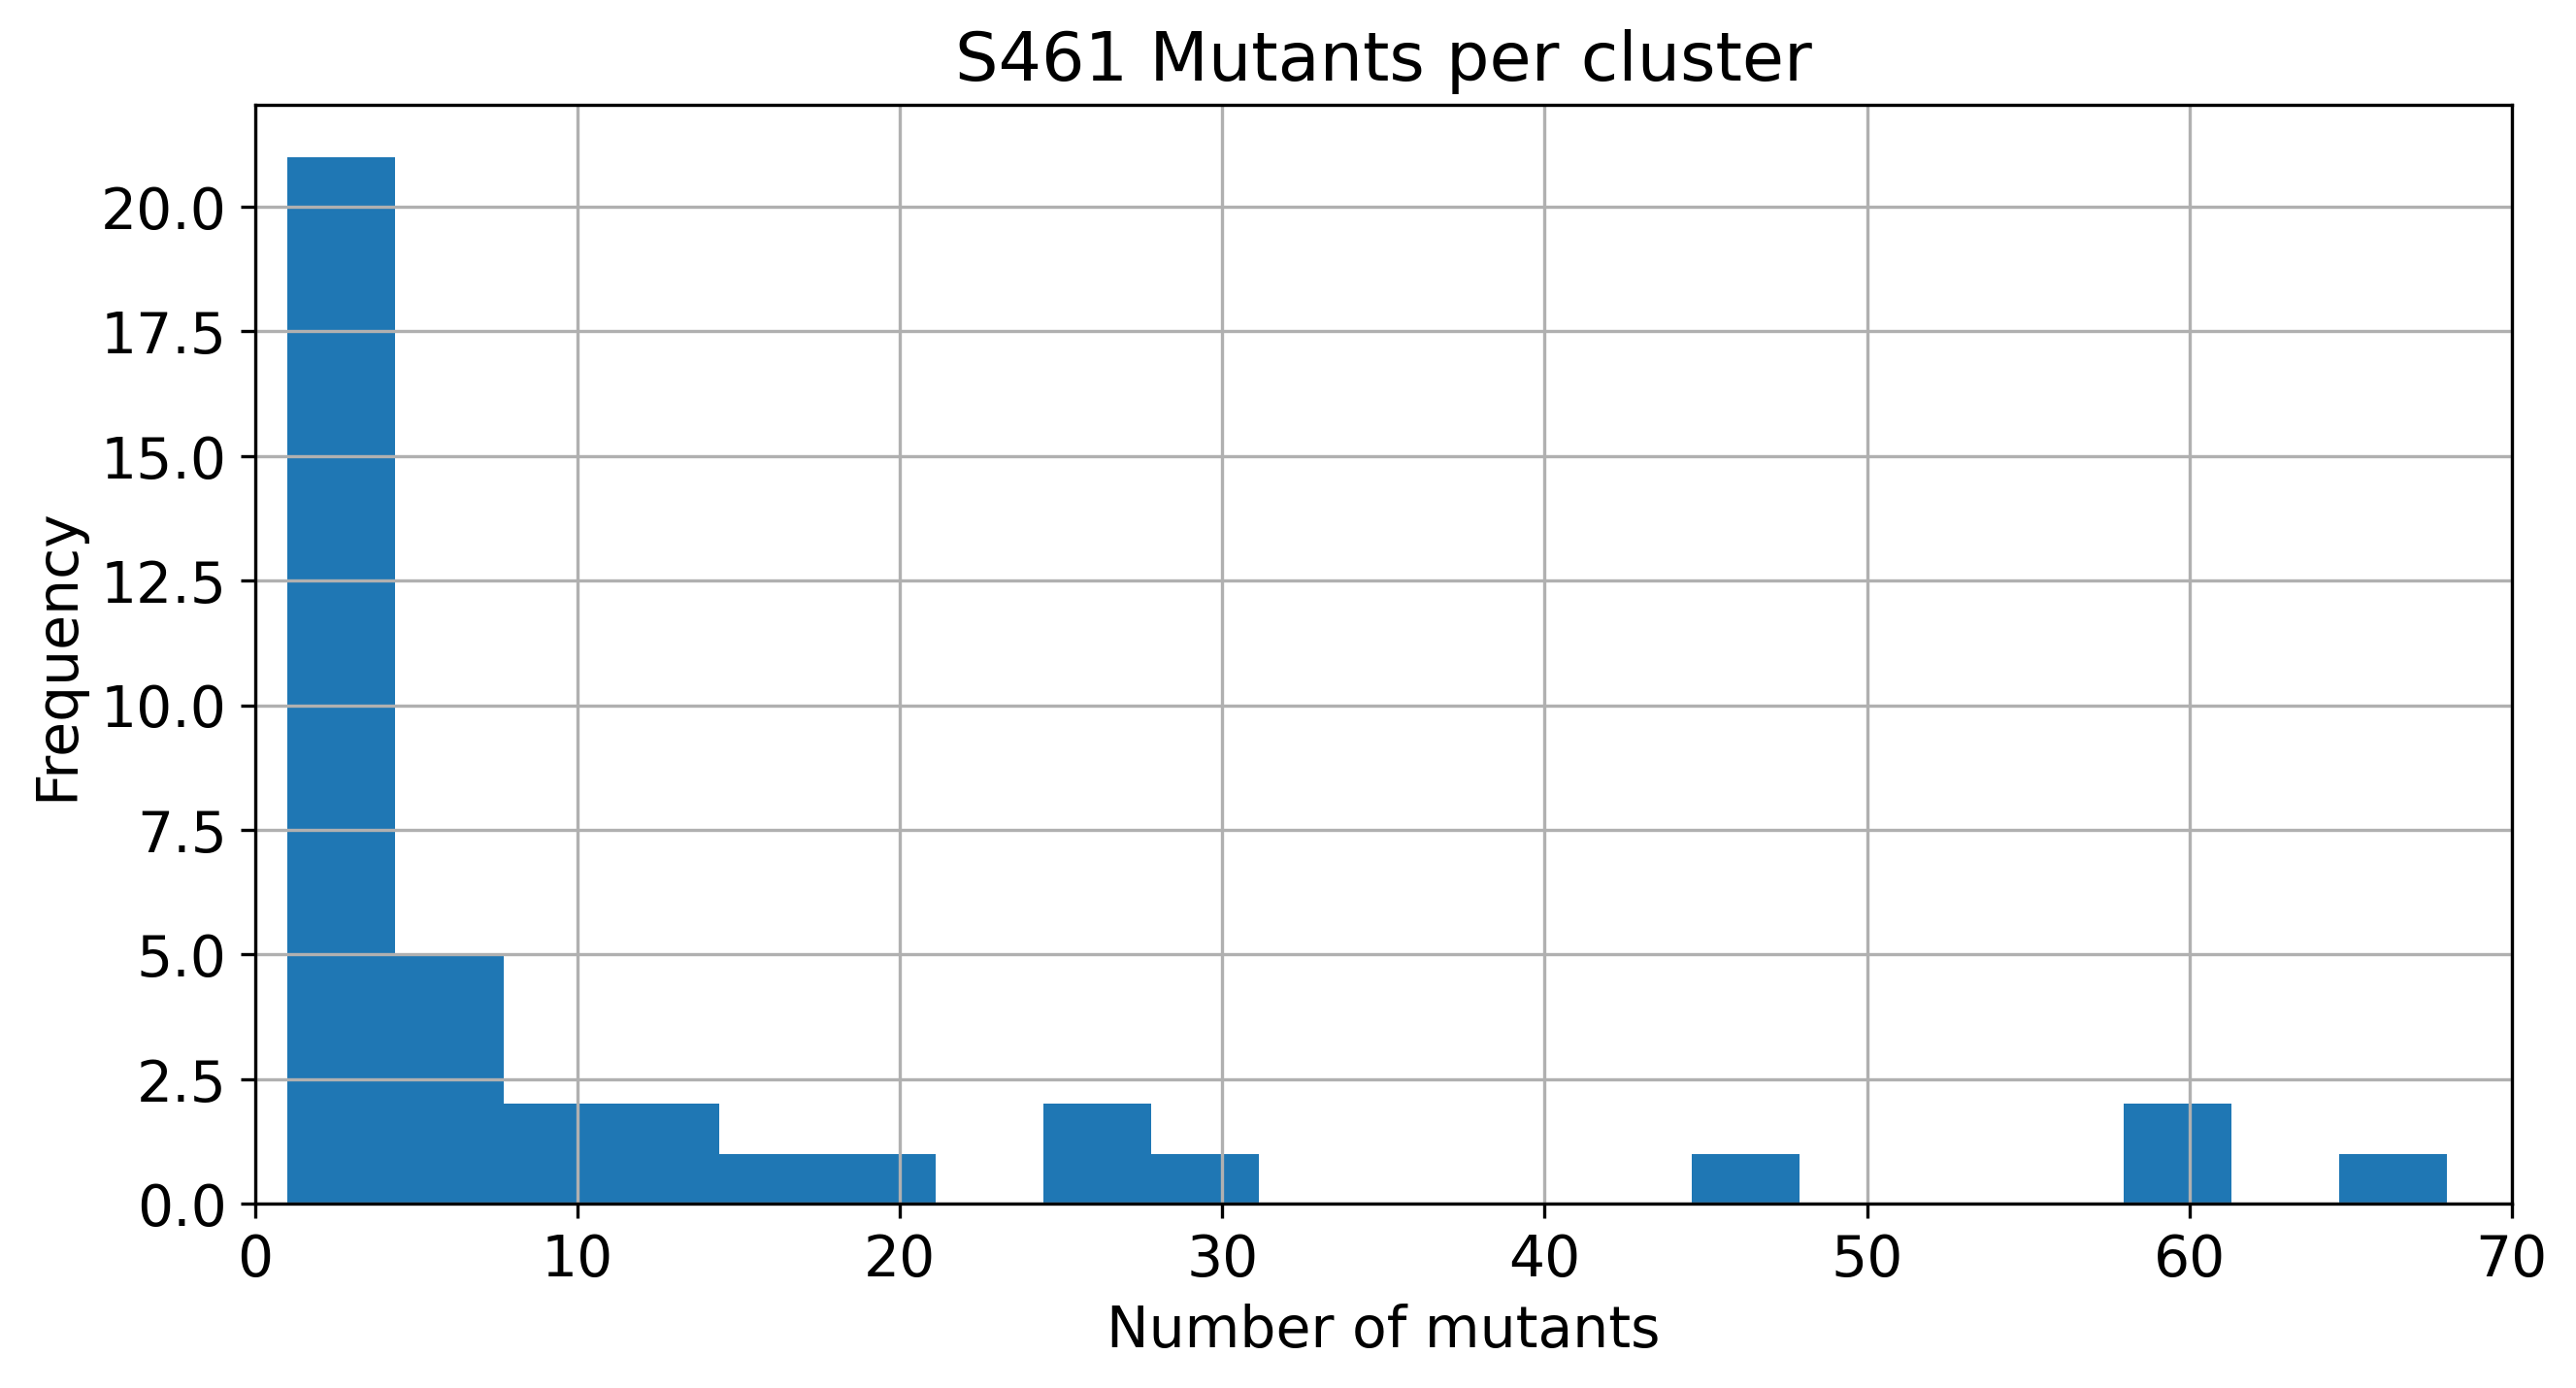

In [48]:
db_class = db

print('Original unique mutations:', len(db_class))

evolutionary = ['tranception', 'msa_transformer', 'esm1v', 'msa', 'esm2', 'ankh']
structural = ['mpnn', 'mif', 'mifst', 'esmif']
supervised = ['MAESTRO', 'ThermoNet', 'INPS', 'PremPS', 'mCSM', 'DUET', 'ACDC', 'I-Mutant3.0', 'SAAFEC', 'MuPro']
untrained = ['DDGun']
potential = ['KORPM', 'PopMusic', 'SDM']
biophysical = ['cartesian_ddg', 'FoldX', 'Evo', 'Cartddg']

original_pred_cols = db_class.columns[db_class.columns.str.contains('|'.join(evolutionary + structural + supervised + untrained + potential + biophysical))]
original_pred_cols = list(original_pred_cols.drop(['msa_file', 'tranception_dms']))
original_pred_cols = [c for c in original_pred_cols if not 'runtime' in c]

db_ddg = db[['ddG_dir']]
db_runtimes = db[[c for c in db.columns if 'runtime' in c]]

original_pred_cols_reduced = deepcopy(original_pred_cols)
for col in [f'esm1v_{i}_dir' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)
for col in [f'msa_{i}_dir' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)

print(original_pred_cols_reduced)

db_class = db_class[original_pred_cols + ['ddG_dir', 'cluster']]

db_class_rescaled = db_class.copy(deep=True)
db_class_rescaled[original_pred_cols] /= db_class_rescaled[original_pred_cols].std()

db_class['mpnn_rosetta_dir'] = db_class['cartesian_ddg_dir'] + db_class['mpnn_20_00_dir']
db_class['random_dir'] = np.random.normal(loc=0, size=len(db_class))
#db_class['korpm_dir'] = db_class['KORPMD_dir']
db_class['ddG'] = db_class['ddG_dir']

db_class = db_class.drop([c+'_dir' for c in ['ACDCNND', 'FoldXD', 'DDGunD', 'CartddgD']], axis=1) #'PopMsD', 'TNetD'

print(f'Detected {len(db_class.loc[db["on_interface_dir"].astype(bool)])} interface mutations')

fig, axes = plt.subplots(1, figsize=(10, 5), dpi=300) 
db_class.groupby('cluster').count().iloc[:, 0].hist(bins=20, ax=axes)
#db_class.groupby('cluster').count().iloc[:, 0].hist(bins=800, ax=axes[1])
plt.xlim([0,70])
plt.title('S461 Mutants per cluster')
plt.xlabel('Number of mutants')
plt.ylabel('Frequency')

db_class

In [9]:
print((db_class.groupby('cluster').count().iloc[:, 0] >= 10).sum(), (db_class.groupby('cluster').count().iloc[:, 0] < 10).sum())

10 28


In [10]:
summ_ = analysis_utils.compute_stats(db_class.reset_index('uid2', drop=True), 
                                    stats=(), 
                                    measurements=['ddG'], grouper='cluster', n_classes=2, n_bootstraps=0, quiet=True)
summ_.to_csv('../data/extended/s461_extended.csv')

In [11]:
summ = analysis_utils.compute_stats(db_class.reset_index('uid2', drop=True), 
                                    stats=('n', 'MCC', 'pred_positives', 'tp', 'auprc', 'spearman', 'ndcg', 'mean_t1s', 'mean_stabilization', 'net_stabilization', 'sensitivity', 'recall@k0.0', 'recall@k1.0', 'mean_reciprocal_rank'), 
                                    measurements=['ddG'], grouper='cluster', n_classes=2, n_bootstraps=100, quiet=True)
tmp1 = summ.reset_index()
tmp1.to_csv('../data/extended/s461_extended_bootstrapped.csv')

In [12]:
remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 'ndcg': 'NDCG', 
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'mean_stabilization': 'Mean Stabilization',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'mean_reciprocal_rank': 'MRR', 'n': 'n', 'MCC': 'MCC', 'recall@k1.0': 'Recall @ k'}

new_remap_cols = {}
for key, value in remap_cols.items():
    new_remap_cols[key + '_mean'] = value + ' mean'
    new_remap_cols[key + '_std'] = value + ' stdev'

s2 = summ.sort_values('net_stabilization_mean', ascending=False).dropna(how='all', axis=1).reset_index()
s3 = s2.loc[s2['model'].isin(original_pred_cols_reduced + [
            'random_dir', 
            'ddG_dir', 
            'q3421_pslm_rfa_2_dir', 
            'q3421_pslm_rfa_3_dir', 
            'q3421_pslm_rfa_4_dir',
            'q3421_pslm_rfa_5_dir',
            'mpnn_rosetta_dir'])
            ].drop('measurement', axis=1)

s4 = s3[['model_type', 'model',
    'recall@k1.0_mean', 'recall@k1.0_std',
    'ndcg_mean', 'ndcg_std', 
    'spearman_mean', 'spearman_std',
    'auprc_mean', 'auprc_std', 
    'MCC_mean', 'MCC_std', 
    'net_stabilization_mean', 'net_stabilization_std',
    ]]
s4['model'] = s4['model'].map(lambda x: remap_names_2.get(x, x[:-4]))
s5 = s4.set_index(['model_type', 'model'])
s5.columns = [new_remap_cols[c] for c in s5.columns]
s5
# Iterate over the DataFrame and update the mean columns
for column in s5.columns:
    if 'mean' in column:
        stdev_column = column.replace('mean', 'stdev')
        s5[column] = s5[column].round(3).astype(str) + ' ± ' + s5[stdev_column].round(2).astype(str)

# Drop the standard deviation columns
s5 = s5[[col for col in s5.columns if 'stdev' not in col]]
s5.columns = [col[:-5] for col in s5.columns]
s6 = s5.reset_index().rename({'model_type': 'Model Type', 'model': 'Model'}, axis=1)
s6

,Model Type,Model,Recall @ k,NDCG,Spearman's ρ,AUPRC,MCC,Net Stabilization
0,unknown,ΔΔG label,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,76.876 ± 34.0
1,evolutionary,ESM-2 15B,0.275 ± 0.11,0.655 ± 0.09,0.306 ± 0.12,0.351 ± 0.05,0.242 ± 0.08,14.118 ± 28.66
2,structural,Rosetta/ProtMPNN,0.288 ± 0.1,0.755 ± 0.1,0.608 ± 0.09,0.479 ± 0.07,0.368 ± 0.06,11.509 ± 26.91
3,evolutionary,Tranception,0.113 ± 0.08,0.515 ± 0.08,0.255 ± 0.11,0.259 ± 0.06,0.182 ± 0.07,2.97 ± 9.78
4,evolutionary,MSA-T median,0.21 ± 0.1,0.582 ± 0.09,0.207 ± 0.1,0.268 ± 0.04,0.13 ± 0.05,-4.12 ± 11.16
5,evolutionary,ESM-2 650M,0.302 ± 0.1,0.63 ± 0.1,0.415 ± 0.11,0.339 ± 0.04,0.221 ± 0.05,-5.965 ± 27.6
6,evolutionary,ESM-1V median,0.303 ± 0.12,0.661 ± 0.1,0.406 ± 0.11,0.405 ± 0.05,0.304 ± 0.04,-9.267 ± 23.19
7,evolutionary,ESM-1V mean,0.303 ± 0.12,0.642 ± 0.09,0.412 ± 0.11,0.408 ± 0.04,0.298 ± 0.04,-10.048 ± 24.03
8,evolutionary,Ankh,0.21 ± 0.1,0.614 ± 0.1,0.427 ± 0.1,0.326 ± 0.04,0.217 ± 0.06,-12.315 ± 27.34
9,evolutionary,MSA-T mean,0.21 ± 0.1,0.575 ± 0.08,0.212 ± 0.1,0.271 ± 0.04,0.121 ± 0.05,-13.122 ± 16.71


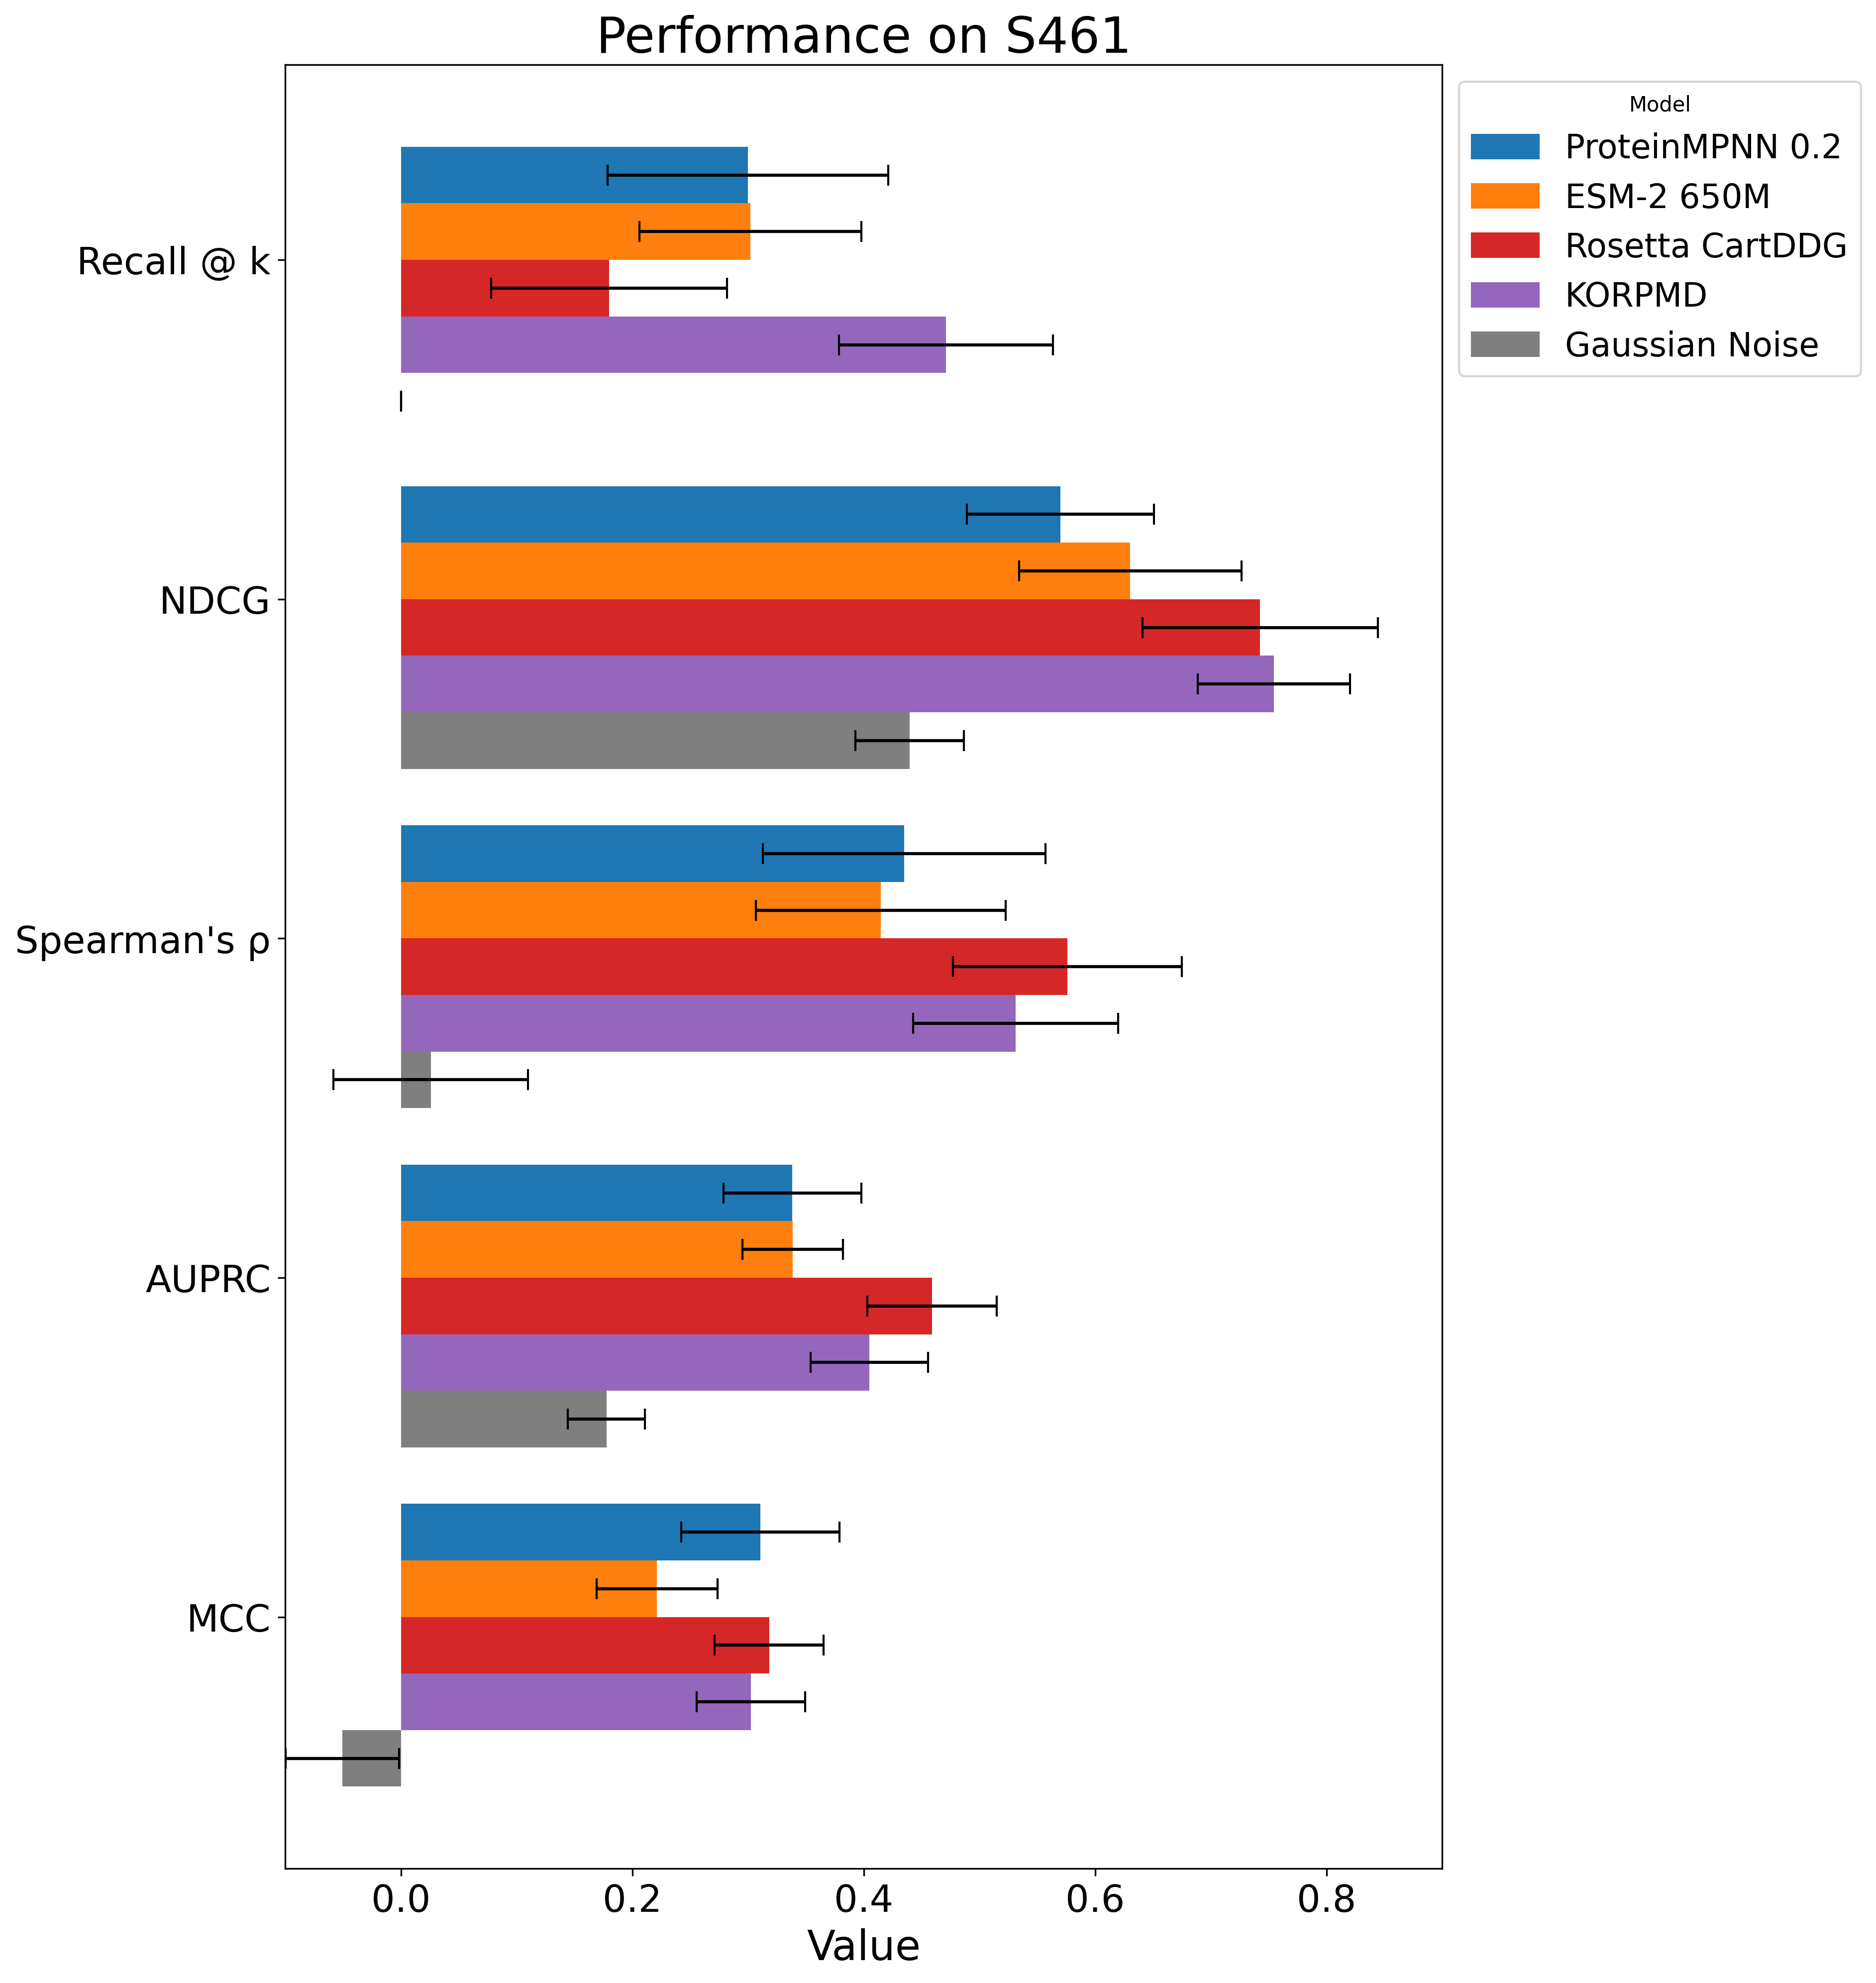

In [13]:
import importlib
importlib.reload(analysis_utils)

remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

tmp3 = tmp1.copy(deep=True)#.set_index('model')
#tmp3['fractional_gain_mean'] = tmp3['net_stabilization_mean'] / tmp3.at['ddG_dir', 'net_stabilization_mean']
#tmp3['fractional_gain_std'] = tmp3['net_stabilization_std'] / tmp3.at['ddG_dir', 'net_stabilization_mean']
#tmp3 = tmp3.reset_index()
#tmp3['fractional_gain_mean']

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 'ndcg': 'NDCG',
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'mean_stabilization': 'Mean Stabilization',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'mean_reciprocal_rank': 'MRR', 'n': 'n', 'MCC': 'MCC', 'recall@k1.0': 'Recall @ k'}

new_remap_cols = {}
for key, value in remap_cols.items():
    new_remap_cols[key + '_mean'] = value + ' mean'
    new_remap_cols[key + '_std'] = value + ' stdev'

s2 = tmp3.sort_values('spearman_mean', ascending=False).dropna(how='all', axis=1).reset_index()
s4 = s2.loc[s2['model'].isin(original_pred_cols_reduced + ['random_dir', 'ddG_dir', 'mpnn_rosetta_dir'])]
#s4 = s3[['model', 'n_mean', 'MCC_mean', 'MCC_std', 'auprc_mean', 'auprc_std', 'spearman_mean', 'spearman_std', 'weighted_ndcg_mean', 'weighted_ndcg_std', 'recall@k1.0_mean', 'recall@k1.0_std', 'mean_stabilization_mean', 'mean_stabilization_std']]
#s4['model'] = s4['model'].map(lambda x: remap_names_2.get(x, x[:-4]))
s5 = s4

tmp2 = s5[[ 'model',  
            'MCC_mean', 'MCC_std',
            'auprc_mean', 'auprc_std',
            #'weighted_spearman_mean', 'weighted_spearman_std',
            'spearman_mean', 'spearman_std',
            #'weighted_ndcg_mean', 'weighted_ndcg_std',
            'ndcg_mean', 'ndcg_std',
            'recall@k1.0_mean', 'recall@k1.0_std', 
            ]].set_index('model')

tmp2.columns = [new_remap_cols[c] for c in tmp2.columns]
tmp2 = tmp2.reset_index().drop_duplicates()

#analysis_utils.make_bar_chart(tmp2, models=['ProteinMPNN 0.2', 'ESM-2 650M', 'Stability Oracle', 'Rosetta CartDDG', 'KORPM', 'DDGun3D', 'MAESTRO', 'Gaussian Noise'], title='Q3421', xlim=(-0.5, 0.8), figsize=(24, 16))
analysis_utils.make_bar_chart(tmp2, models=['mpnn_20_00', 'esm2_650M', 'stability-oracle', 'cartesian_ddg', 'KORPMD', 'random'], title='S461', xlim=(-0.1, 0.9), figsize=(10, 16))

In [14]:
tmp2

,model,MCC mean,MCC stdev,AUPRC mean,AUPRC stdev,Spearman's ρ mean,Spearman's ρ stdev,NDCG mean,NDCG stdev,Recall @ k mean,Recall @ k stdev
0,ddG,1.000000,0.000000,1.000000,9.727459e-17,1.000000,8.714803e-17,1.000000,1.909970e-16,1.000000,0.000000
1,mpnn_rosetta,0.368403,0.064726,0.479373,6.666822e-02,0.608361,8.796281e-02,0.754873,1.009602e-01,0.287754,0.101355
2,cartesian_ddg,0.318247,0.047184,0.459127,5.599670e-02,0.575938,9.898034e-02,0.742646,1.017215e-01,0.179905,0.101846
3,PopMusic,0.268919,0.039640,0.373636,4.254326e-02,0.572024,8.361280e-02,0.524278,5.789746e-02,0.092373,0.083860
4,MAESTRO,0.315270,0.041637,0.361633,5.353493e-02,0.569228,8.533521e-02,0.519741,5.946583e-02,0.000000,0.000000
5,INPS3D,0.208015,0.051203,0.357595,6.680130e-02,0.557181,8.466458e-02,0.532712,9.103123e-02,0.099226,0.077528
6,PremPS,0.181527,0.097998,0.342573,4.666532e-02,0.554327,1.074627e-01,0.712528,1.191755e-01,0.228929,0.110186
7,KORPMD,0.302550,0.046897,0.404735,5.080028e-02,0.531064,8.860132e-02,0.754411,6.571848e-02,0.471127,0.092451
8,DDGun3D,0.306377,0.061546,0.376241,5.453448e-02,0.529634,1.082400e-01,0.728327,1.056344e-01,0.209750,0.092687
9,DUET,0.244870,0.051789,0.325506,4.219994e-02,0.524373,9.928306e-02,0.526338,6.223330e-02,0.095063,0.119204


In [49]:
zs_feats = ['delta_kdh', 'delta_vol', 'rel_ASA']

db_ens = db_class.copy(deep=True).reset_index().set_index('uid2').reset_index(drop=True).set_index('uid')#.join(db_feats_2.drop(['SOL_ACC_dir', 'SOL_ACC_inv'], axis=1))
#db_ens = db_ens.rename({'ddG_dir': 'ddG'}, axis=1) 
#models = original_pred_cols_reduced + [c + '_dir' for c in zs_feats]
models = list(db_class.columns) #+ [z+'_dir' for z in zs_feats]
models.remove('ddG_dir')
models = [c for c in models if not 'q3421' in c]
#models.remove('ddG_dir')

#for zs in zs_feats:
#    db_ens[zs+'_dir'] = db_ens[zs]

print(len(db_ens))
db_ens['random_dir'] = np.random.normal(size=len(db_ens)) - 0.5
#db_ens['random_inv'] = np.random.normal(size=len(db_ens)) - 0.5
#db_ens = db_ens.drop(['KORPMD_dir', 'CartddgD_dir', 'FoldXD_dir', 'EvoD_dir', 'Dyna2D_dir', 'PopMsD_dir', 'DDGunD_dir', 'TNetD_dir', 'ACDCNND_dir'], axis=1)
dfm = db_ens.copy(deep=True)
models

461


['KORPMD_dir',
 'EvoD_dir',
 'ACDC-NN-Seq_dir',
 'ACDC-NN-Seq_inv',
 'ACDC-NN_dir',
 'ACDC-NN_inv',
 'DDGun3D_dir',
 'DDGun3D_inv',
 'DDGun_dir',
 'DDGun_inv',
 'DUET_dir',
 'DUET_inv',
 'FoldX_dir',
 'FoldX_inv',
 'I-Mutant3.0-Seq_dir',
 'I-Mutant3.0-Seq_inv',
 'I-Mutant3.0_dir',
 'I-Mutant3.0_inv',
 'INPS-Seq_dir',
 'INPS-Seq_inv',
 'INPS3D_dir',
 'INPS3D_inv',
 'MAESTRO_dir',
 'MAESTRO_inv',
 'MuPro_dir',
 'MuPro_inv',
 'PopMusic_dir',
 'PopMusic_inv',
 'PremPS_dir',
 'PremPS_inv',
 'SAAFEC-Seq_dir',
 'SAAFEC-Seq_inv',
 'SDM_dir',
 'SDM_inv',
 'ThermoNet_dir',
 'ThermoNet_inv',
 'esmif_monomer_dir',
 'mCSM_dir',
 'mCSM_inv',
 'mpnn_10_00_dir',
 'mpnn_20_00_dir',
 'mpnn_30_00_dir',
 'pll_esmif_monomer_dir',
 'esmif_multimer_dir',
 'pll_esmif_multimer_dir',
 'esm2_3B_dir',
 'esm2_15B_half_dir',
 'msa_1_dir',
 'msa_2_dir',
 'msa_3_dir',
 'msa_4_dir',
 'msa_5_dir',
 'msa_transformer_median_dir',
 'msa_transformer_mean_dir',
 'tranception_dir',
 'esm2_150M_dir',
 'esm2_650M_dir',
 'esm1v

In [50]:
weights = [1, 0.5, 0.2]
#weights2 = [0.8, 0.3]

all_cols = []

tmp = []
for model1 in models:
    for model2 in models:
        if model1[-4:] == model2[-4:] and model1 != model2: #(model1.split('_')[0] != model2.split('_')[0]) and (model1[:4] != model2[:4]) and
            for weight in weights:
                tmp.append(pd.Series(dfm[model1]/dfm[model1].std() + dfm[model2]/dfm[model2].std() * weight, name=f'{model1} + {model2} * {weight}'))
                all_cols.append(f'{model1} + {model2} * {weight}')
                #for model3 in models:
                #    if model2 != model3 and model1 != model3:
                #        for weight2 in weights2:
                #            tmp.append(pd.Series(dfm[model1] + dfm[model2] * weight + dfm[model3] * weight2, name=f'{model1} + {model2} * {weight} + {model3} * {weight2}'))
                #            all_cols.append(f'{model1} + {model2} * {weight} + {model3} * {weight2}')

dfm = pd.concat([dfm] + tmp, axis=1)
dfm = dfm.join(db_runtimes)
#dfm.to_csv(os.path.join(path, 'results', 'ensemble_s461_2_models_3_weights_preds.csv'))
dfm.columns

Index(['KORPMD_dir', 'EvoD_dir', 'ACDC-NN-Seq_dir', 'ACDC-NN-Seq_inv',
       'ACDC-NN_dir', 'ACDC-NN_inv', 'DDGun3D_dir', 'DDGun3D_inv', 'DDGun_dir',
       'DDGun_inv',
       ...
       'runtime_esm1v_3_dir', 'runtime_esm1v_4_dir', 'runtime_esm1v_5_dir',
       'runtime_esm1v_median_dir', 'runtime_esm1v_mean_dir',
       'runtime_ankh_dir', 'runtime_mif_dir', 'runtime_mifst_dir',
       'runtime_korpm_dir', 'runtime_cartesian_ddg_dir'],
      dtype='object', length=9289)

In [37]:
def get_summary_df(db_complete, cols=None, saveloc=os.path.join(path, 'results', 'ensemble_s461_2_models_3_weights_results.csv'), stats=(), stacked=False):

    assert os.path.exists(os.path.dirname(saveloc))
    assert not os.path.exists(saveloc)
    #if cols is None:
    #    cols = db_complete.columns.drop(['code'])#, 'ddG_dir', 'ddG_inv'])

    #if not stacked:
    #    db_stacked = stack_frames(db_complete)
    #else:
    #    db_stacked = db_complete
    #db_stacked['code'] = list(db_stacked.reset_index()['uid'].str[:4])

    df_summ = analysis_utils.compute_stats(db_complete, stats=(), grouper='cluster', measurements=['ddG']).reset_index().set_index(['measurement', 'model'])#.join(df_reg) #.drop('n_total', axis=1))
    df_summ = df_summ.reset_index().rename({'index': 'model'}, axis=1).set_index(['measurement', 'model_type', 'model', 'class'])
    df_summ = df_summ.sort_index(level=1).sort_index(level=0)#.drop_duplicates()
    df_summ.to_csv(saveloc)
    return df_summ

In [18]:
import importlib
importlib.reload(analysis_utils)
# takes a long time to compute and has already been done
#d1 = get_summary_df(dfm, saveloc=os.path.join(path, 'data', 'pairwise', 'pairwise_s461_combinations_3_weights.csv'), stats=()) 

d1 = pd.read_csv(os.path.join(path, 'data', 'pairwise', 'pairwise_s461_combinations_3_weights.csv')).set_index(['measurement', 'model_type', 'model', 'class'])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8322 [00:00<?, ?it/s]

['ACDC-NN_dir', 'DDGun3D_dir', 'DUET_dir', 'Dynamut_dir', 'FoldX_dir', 'EvoD_dir', 'I-Mutant3.0_dir', 'INPS3D_dir', 'MAESTRO_dir', 'MUpro_dir', 'PopMusic_dir', 'PremPS_dir', 'ThermoNet_dir', 'SAAFEC-Seq_dir', 'SDM_dir', 'ThermoNet_dir', 'mCSM_dir', 'cartesian_ddg_dir', 'esm1v_mean_dir', 'msa_transformer_mean_dir', 'tranception_dir', 'ankh_dir', 'esm2_dir', 'esmif_multimer_dir', 'mpnn_20_00_dir', 'mif_dir', 'mifst_dir', 'korpm_dir', 'mutcomputex_dir', 'stability-oracle_dir']
461
0.12048281269827099
['Rosetta CartDDG', 'PremPS_dir', 'PopMusic_dir', 'MAESTRO_dir', 'INPS3D_dir', 'DDGun3D_dir', 'DUET_dir', 'ACDC-NN_dir', 'KORPM', 'mCSM_dir', 'SDM_dir', 'ThermoNet_dir', 'I-Mutant3.0_dir', 'SAAFEC-Seq_dir', 'EvoD_dir', 'MIF', 'Ankh', 'ProteinMPNN 0.2', 'ESM-1V mean', 'ESM-IF', 'MIF-ST', 'FoldX_dir', 'Tranception', 'MSA-T mean']


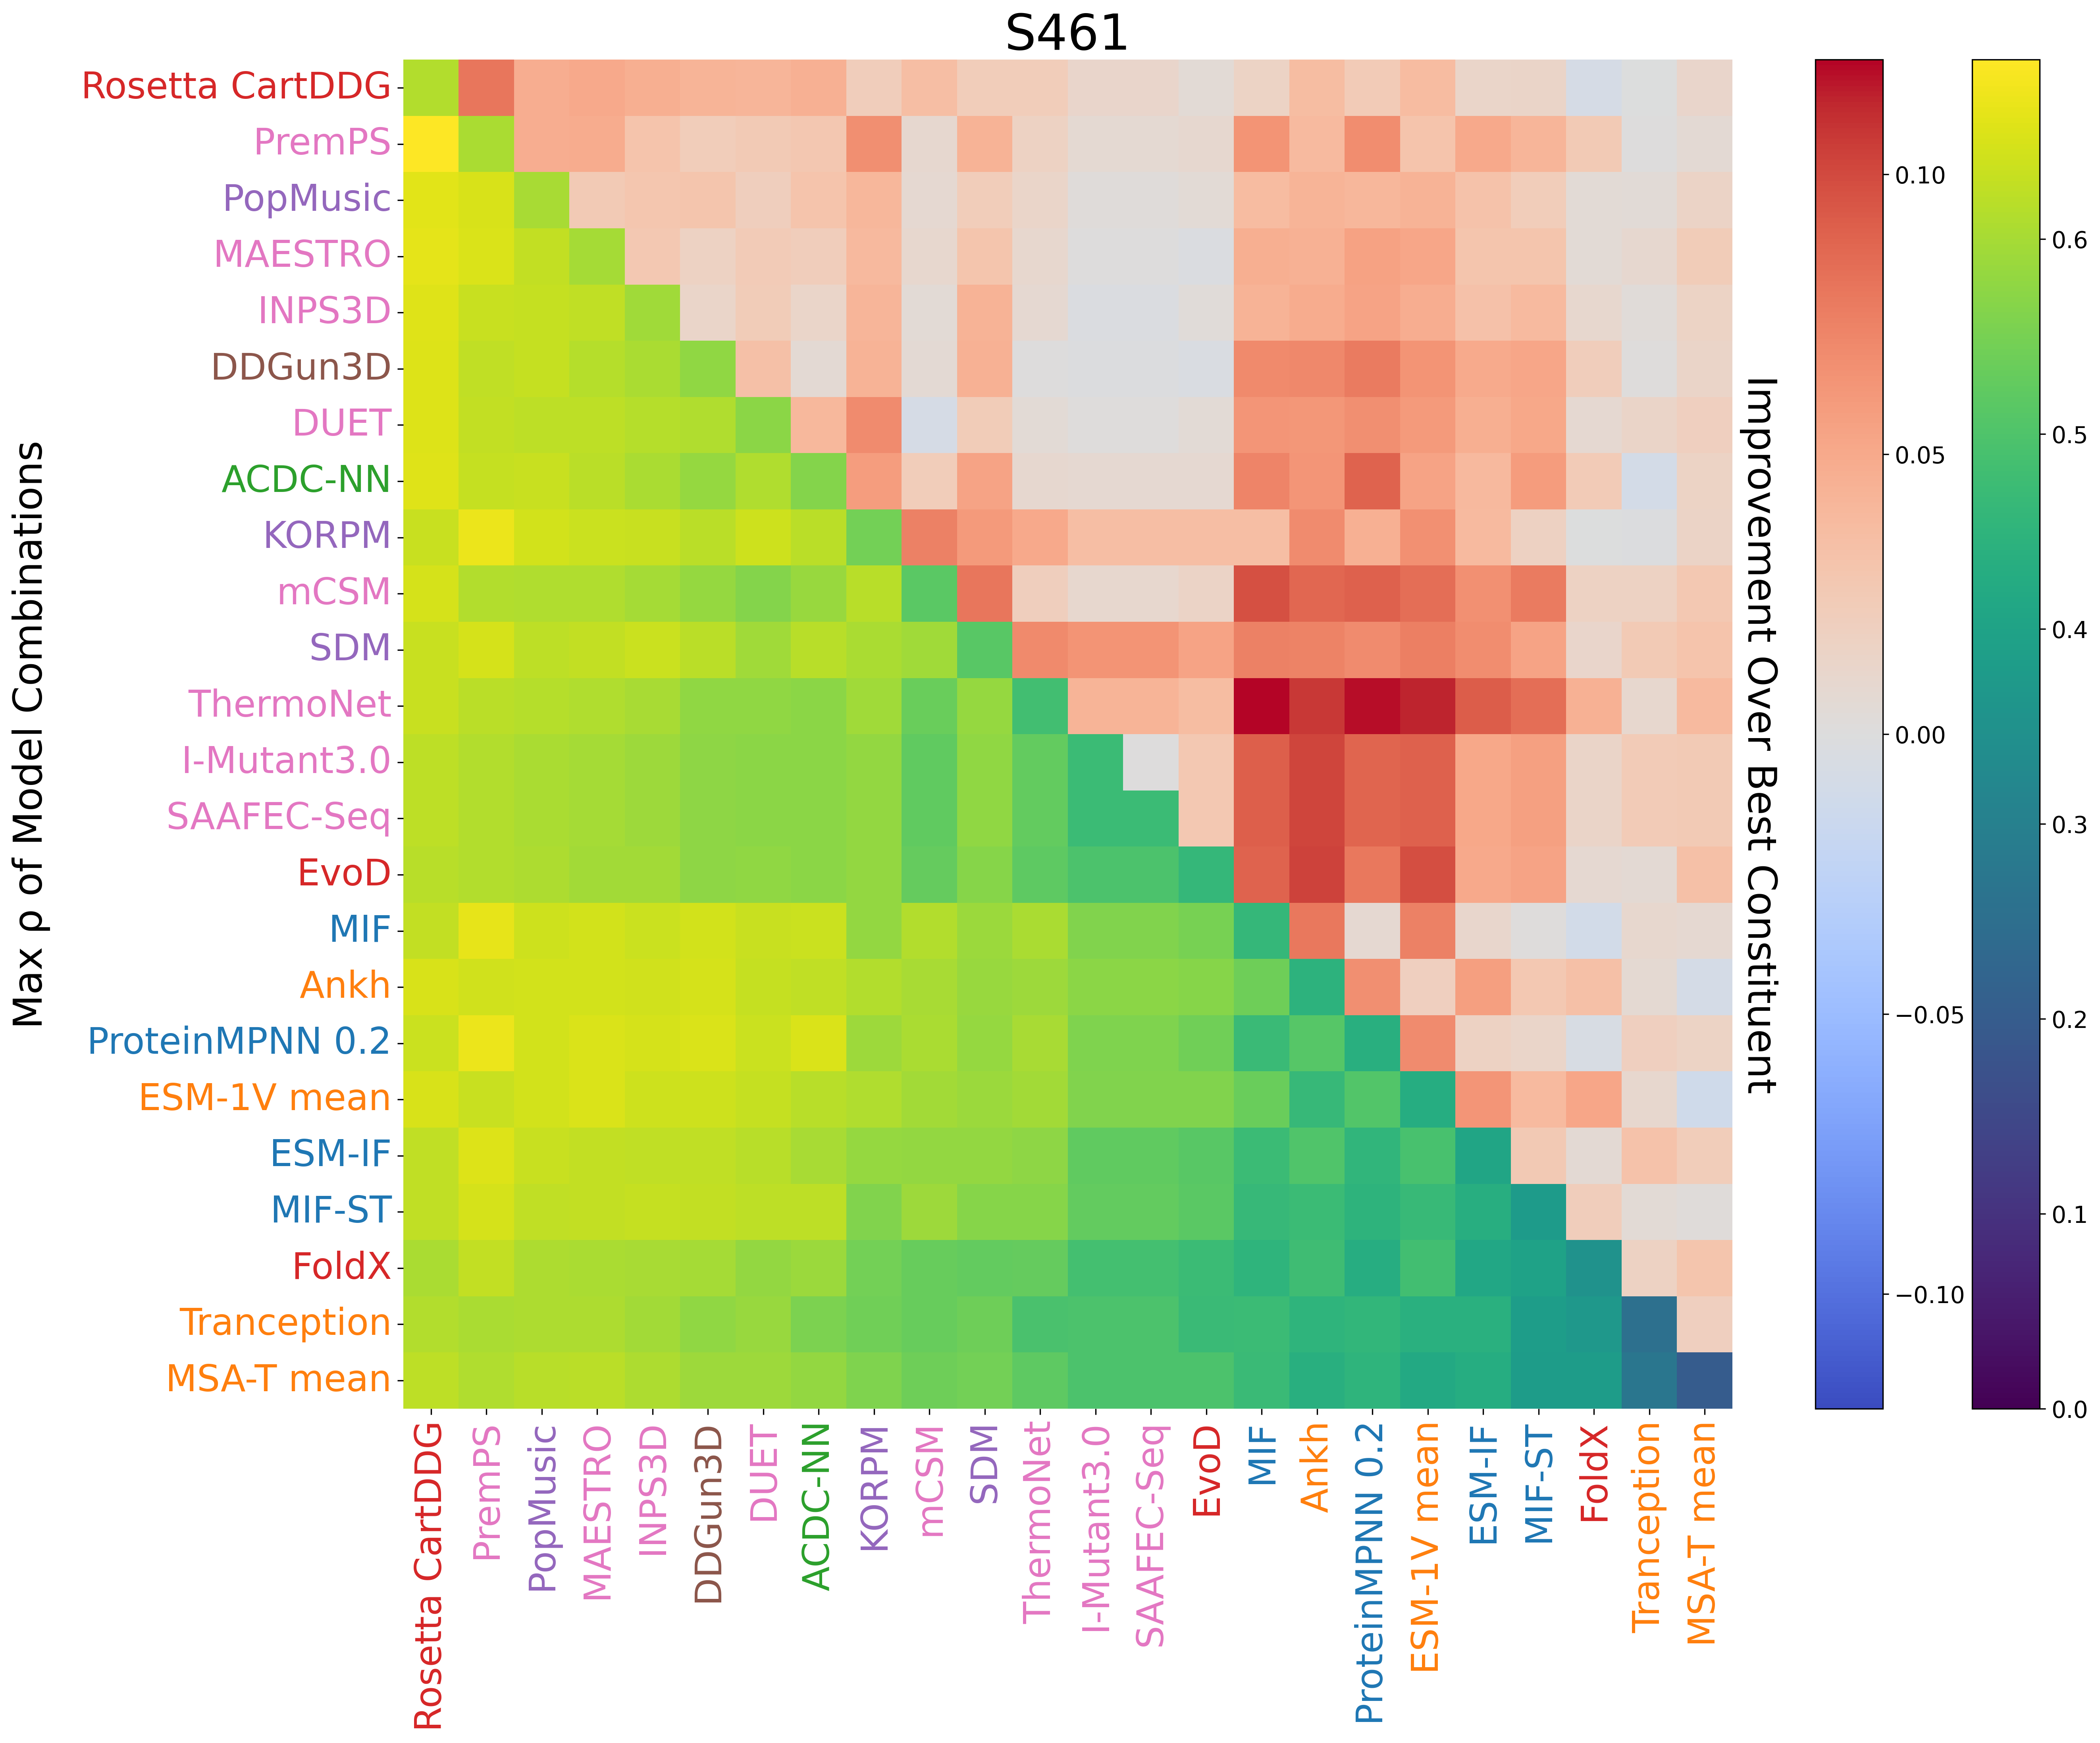

,model1,weight1,model2,weight2,spearman,corr,runtime_cpu,runtime_gpu
rank,,,,,,,,
1,PremPS,1.0,Rosetta CartDDG,1.0,0.692061,0.523972,250826.999900,-0.000100
2,PremPS,1.0,ProteinMPNN 0.2,0.5,0.672140,0.260751,-0.000100,4.562497
3,PremPS,1.0,KORPM,0.5,0.670947,0.435620,1.457998,-0.000100
4,PremPS,1.0,MIF,0.5,0.667488,0.302040,-0.000100,42.318466
5,MAESTRO,1.0,Rosetta CartDDG,1.0,0.662437,0.620230,250826.999900,-0.000100
6,PopMusic,1.0,Rosetta CartDDG,1.0,0.660307,0.657760,250826.999900,-0.000100
7,INPS3D,1.0,Rosetta CartDDG,1.0,0.658911,0.627435,250826.999900,-0.000100
8,ACDC-NN,1.0,Rosetta CartDDG,1.0,0.657658,0.601310,250826.999900,-0.000100
9,DDGun3D,1.0,Rosetta CartDDG,1.0,0.655000,0.643490,250826.999900,-0.000100


In [55]:
import importlib
importlib.reload(analysis_utils)


subset  = [ 'ACDC-NN_dir', 'DDGun3D_dir', 'DUET_dir', 'Dynamut_dir', 'FoldX_dir',
            'EvoD_dir', 'I-Mutant3.0_dir', 'INPS3D_dir', 'MAESTRO_dir', 'MUpro_dir',
            'PopMusic_dir', 'PremPS_dir', 'ThermoNet_dir', 'SAAFEC-Seq_dir', 'SDM_dir',     
            'ThermoNet_dir', 'mCSM_dir', 'cartesian_ddg_dir', 'esm1v_mean_dir',
            'msa_transformer_mean_dir', 'tranception_dir', 'ankh_dir', 'esm2_dir',
            'esmif_multimer_dir', 'mpnn_20_00_dir', 'mif_dir', 'mifst_dir',
            'korpm_dir', 'mutcomputex_dir', 'stability-oracle_dir'
        ]

print(subset)

#custom_colors = dict(zip([key+'_dir' for key in custom_colors.keys()], list(custom_colors.values())))
#print(custom_colors)

measurement = 'ddG'
statistic = 'spearman'

db_ddg_ = db_ddg.copy(deep=True)
db_ddg_ = db_ddg_.rename({'ddG_dir': 'ddG'}, axis=1).reset_index('uid2', drop=True)
d3 = d1.copy(deep=True)

#dfm['code'] = dfm.index.str[:4]

stat_df_, delta_df = analysis_utils.model_combinations_heatmap(d3, dfm.fillna(0), db_ddg_, statistic, measurement, threshold=0, subset=subset, n_bootstraps=0, grouper=None, upper='delta', annot=False, title='S461')
#stat_df = analysis_utils.model_combinations_heatmap_2(d2, dfm, statistic, direction, upper, threshold=None, custom_colors=custom_colors)
stat_df = stat_df_
stat_df = stat_df.drop_duplicates(subset=[f'{statistic}', 'runtime_cpu', 'runtime_gpu']).reset_index(drop=True).sort_values(f'{statistic}', ascending=False).reset_index(drop=True).reset_index()
stat_df['model1'] = stat_df['model1'].map(lambda x: remap_names_2.get(x, x[:-4]))
stat_df['model2'] = stat_df['model2'].map(lambda x: remap_names_2.get(x, x[:-4]))

stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models_ = set(list(out['model1']) + list(out['model2']))
stat_df

In [42]:
stat_df_ = stat_df.applymap(lambda x: np.nan if x==-0.0001 else x)
stat_df_ = stat_df.applymap(lambda x: round(x, 2) if type(x)==float else x)
for source, target in remap_names.items():
    stat_df_.loc[stat_df_['model1']==source, 'model1'] = target
    stat_df_.loc[stat_df_['model2']==source, 'model2'] = target
stat_df_ = stat_df_.reset_index().drop('weight1', axis=1).rename({'rank': 'Rank', 'model1': 'Base model', 'model2': 'Added Model', 'weight2': 'Weight', 'corr': 'Model Correlation', 'runtime_cpu': 'CPU time (s)', 'runtime_gpu': 'GPU time (s)', 'spearman': 'Spearman\'s rho'}, axis=1)
#stat_df_.to_csv('../data/stat_df_s461.csv')
stat_df_.head(30)

,Rank,Base model,Added Model,Weight,Spearman's rho,Model Correlation,CPU time (s),GPU time (s)
0,1,PremPS,Rosetta CartDDG,1.0,0.69,0.52,-0.00,-0.0
1,2,PremPS,ProteinMPNN 0.2,0.5,0.67,0.26,-0.00,-0.0
2,3,PremPS,KORPMD,0.5,0.67,0.44,1.46,-0.0
3,4,PremPS,MIF,0.5,0.67,0.30,-0.00,-0.0
4,5,MAESTRO,Rosetta CartDDG,1.0,0.66,0.62,-0.00,-0.0
5,6,PopMusic,Rosetta CartDDG,1.0,0.66,0.66,-0.00,-0.0
6,7,INPS3D,Rosetta CartDDG,1.0,0.66,0.63,-0.00,-0.0
7,8,ACDC-NN,Rosetta CartDDG,1.0,0.66,0.60,-0.00,-0.0
8,9,DDGun3D,Rosetta CartDDG,1.0,0.66,0.64,-0.00,-0.0
9,10,PremPS,ESM-IF,0.5,0.65,0.29,-0.00,-0.0


461
42.424
['Tranception', 'MSA-T mean', 'ESM-1V mean', 'PremPS_dir', 'Rosetta CartDDG', 'MIF-ST', 'Ankh', 'I-Mutant3.0_dir', 'SAAFEC-Seq_dir', 'INPS3D_dir', 'PopMusic_dir', 'ESM-IF', 'mCSM_dir', 'DUET_dir', 'MIF', 'MAESTRO_dir', 'ProteinMPNN 0.2', 'ACDC-NN_dir', 'DDGun3D_dir', 'KORPM', 'EvoD_dir', 'SDM_dir', 'ThermoNet_dir', 'FoldX_dir']


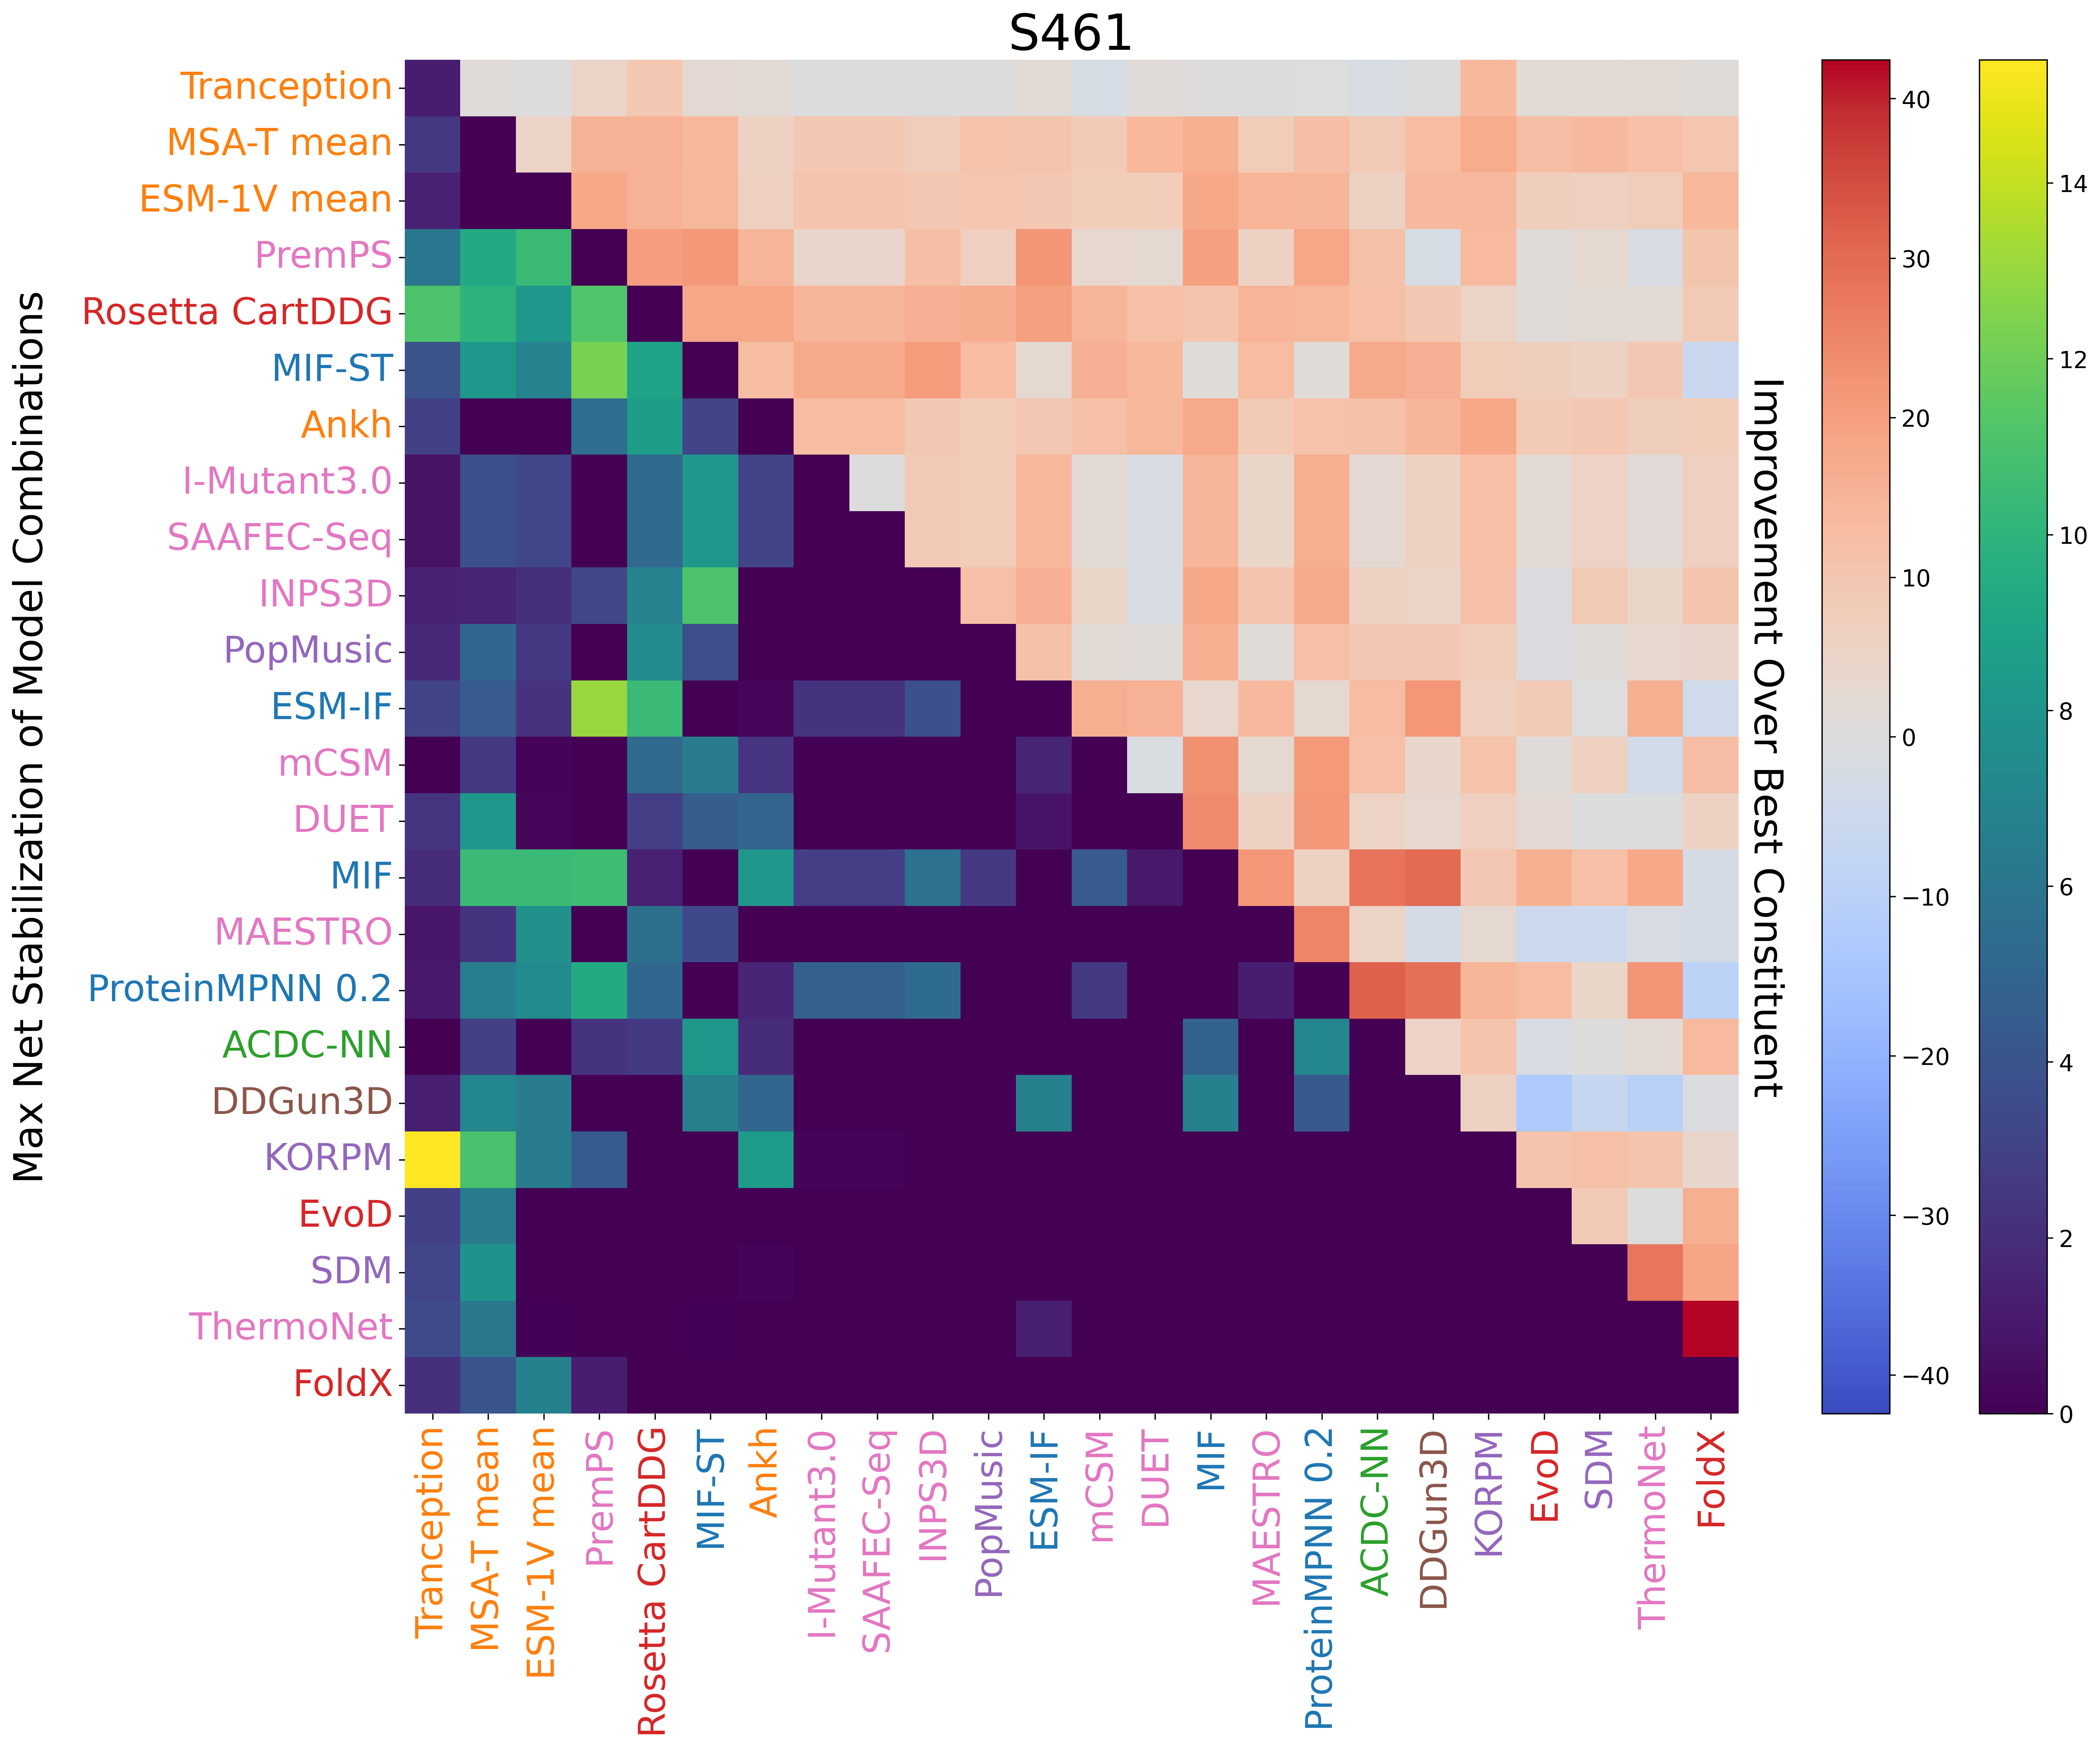

{'SDM', 'MAESTRO', 'ACDC-NN', 'DDGun3D', 'Tranception', 'PremPS', 'MIF-ST', 'ESM-1V mean', 'I-Mutant3.0', 'Rosetta CartDDG', 'ProteinMPNN 0.2', 'INPS3D', 'KORPM', 'ESM-IF', 'MSA-T mean', 'PopMusic', 'MIF', 'DUET', 'Ankh'}


,model1,weight1,model2,weight2,net_stabilization,corr,runtime_cpu,runtime_gpu
rank,,,,,,,,
1,Tranception,1.0,KORPM,0.5,15.400,0.293999,1.457998,6012.661391
2,PremPS,1.0,ESM-IF,1.0,13.046,0.288006,-0.000100,78.337373
3,PremPS,1.0,MIF-ST,1.0,12.242,0.264921,-0.000100,16.700319
4,PremPS,1.0,Rosetta CartDDG,0.5,11.170,0.523972,250826.999900,-0.000100
5,MIF-ST,1.0,INPS3D,0.5,11.080,0.315261,-0.000100,16.700319
6,Tranception,1.0,Rosetta CartDDG,0.5,11.015,0.233294,250826.999900,6012.661391
7,KORPM,1.0,MSA-T mean,1.0,10.989,0.176015,1.457998,4138.703709
8,PremPS,1.0,MIF,1.0,10.575,0.302040,-0.000100,42.318466
9,MIF,1.0,MSA-T mean,0.5,10.462,0.261955,-0.000100,4181.022276


In [56]:
measurement = 'ddG'
statistic = 'net_stabilization'

db_ddg_ = db_ddg.copy(deep=True)
db_ddg_ = db_ddg_.rename({'ddG_dir': 'ddG'}, axis=1).reset_index('uid2', drop=True)
d3 = d1.copy(deep=True)

#dfm['code'] = dfm.index.str[:4]

stat_df_, delta_df = analysis_utils.model_combinations_heatmap(d3, dfm.fillna(0), db_ddg_, statistic, measurement, threshold=0, subset=subset, n_bootstraps=0, grouper=None, upper='delta', annot=False, title='S461')
#stat_df = analysis_utils.model_combinations_heatmap_2(d2, dfm, statistic, direction, upper, threshold=None, custom_colors=custom_colors)
stat_df = stat_df_
stat_df = stat_df.drop_duplicates(subset=[f'{statistic}', 'runtime_cpu', 'runtime_gpu']).reset_index(drop=True).sort_values(f'{statistic}', ascending=False).reset_index(drop=True).reset_index()
stat_df['model1'] = stat_df['model1'].map(lambda x: remap_names_2.get(x, x[:-4]))
stat_df['model2'] = stat_df['model2'].map(lambda x: remap_names_2.get(x, x[:-4]))

stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models_ = set(list(out['model1']) + list(out['model2']))
print(models_)
stat_df

In [ ]:
stat_df_ = stat_df.applymap(lambda x: np.nan if x==-0.0001 else x)
stat_df_ = stat_df.applymap(lambda x: round(x, 2) if type(x)==float else x)
for source, target in remap_names.items():
    stat_df_.loc[stat_df_['model1']==source, 'model1'] = target
    stat_df_.loc[stat_df_['model2']==source, 'model2'] = target
stat_df_ = stat_df_.reset_index().drop('weight1', axis=1).rename({'rank': 'Rank', 'model1': 'Base model', 'model2': 'Added Model', 'weight2': 'Weight', 'corr': 'Model Correlation', 'runtime_cpu': 'CPU time (s)', 'runtime_gpu': 'GPU time (s)', 'spearman': 'Spearman\'s rho'}, axis=1)
#stat_df_.to_csv('../data/stat_df_net_stab_s461.csv')
stat_df_.head(30)

,Rank,Base model,Added Model,Weight,net_stabilization,Model Correlation,CPU time (s),GPU time (s)
0,1,Tranception,KORPMD,0.5,15.40,0.29,0.69,6012.66
1,2,PremPS,ESM-IF,1.0,13.05,0.29,-0.00,78.34
2,3,PremPS,MIF-ST,1.0,12.24,0.26,-0.00,16.70
3,4,ESM-IF,Rosetta CartDDG,0.5,11.90,0.46,368118.00,78.34
4,5,MIF-ST,INPS3D,0.5,11.08,0.32,-0.00,16.70
5,6,KORPMD,MSA-T mean,1.0,10.99,0.18,0.69,4138.70
6,7,Rosetta CartDDG,Tranception,1.0,10.93,0.24,368118.00,6012.66
7,8,MIF,ESM-2 3B,0.5,10.88,0.32,-0.00,121.68
8,9,PremPS,MIF,1.0,10.57,0.30,-0.00,42.32
9,10,MIF,MSA-T mean,0.5,10.46,0.26,-0.00,4181.02


In [61]:
supp = d1.xs('ddG')[['auprc', 'mean_stabilization', 'net_stabilization', 'weighted_ndcg', 'weighted_spearman', 'auppc', 'aumsc']].reset_index().drop(['model_type', 'class'], axis=1)#.set_index('model')
selection = ['INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 'DUET', 'Dynamut', 'FoldX', 'I-Mutant3.0', 'I-Mutant3.0-Seq',
             'tranception', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'mpnn_20_00', 'esmif_multimer', 'ACDC-NN', 'cartesian_ddg', 'SAAFEC-Seq', 'SDM', 'ThermoNet', 'mCSM']
selection = [s+'_dir' for s in selection]
supp[['model1', 'weight1', 'model2', 'weight2']] = supp['model'].apply(analysis_utils.process_index).apply(pd.Series)
supp = supp.loc[supp['model1'].isin(selection) & supp['model2'].isin(selection)]
df1 = analysis_utils.get_stat_df(supp, 'weighted_ndcg', new_dir='dir')
df2 = analysis_utils.get_stat_df(supp, 'auppc', new_dir='dir')
df3 = analysis_utils.get_stat_df(supp, 'net_stabilization', new_dir='dir')

assert len(df1)==len(df2)
assert len(df2)==len(df3)

#df_merged = df1.merge(df2, how='outer', on=['model1', 'weight1', 'model2', 'weight2']).merge(df3, how='outer', on=['model1', 'weight1', 'model2', 'weight2'])
df_merged = pd.concat([df1, df2['auppc'], df3['net_stabilization']], axis=1)

df_merged['models'] = df_merged.apply(lambda row: set([row['model1'], row['model2']]), axis=1)
df_merged['models'] = df_merged['models'].apply(frozenset)

idx1 = df_merged.groupby('models')['weighted_ndcg'].idxmax()
idx2 = df_merged.groupby('models')['auppc'].idxmax()
idx3 = df_merged.groupby('models')['net_stabilization'].idxmax()

df_merged_2 = pd.concat([df_merged.loc[idx1], df_merged.loc[idx2], df_merged.loc[idx3]]).drop_duplicates()

dd1 = df_merged_2.sort_values('weighted_ndcg', ascending=False).head(10) #16
dd2 = df_merged_2.sort_values('auppc', ascending=False).head(10)
dd3 = df_merged_2.sort_values('net_stabilization', ascending=False).head(10)
dd = pd.concat([dd1, dd2, dd3]).drop_duplicates().drop('models', axis=1)
dd['model1'] = dd['model1'].replace(remap_names)
dd['model2'] = dd['model2'].replace(remap_names)
dd = dd.drop('weight1', axis=1)
dd.columns = ['Model 1', 'Model 2', 'Weight 2', 'wNDCG', 'AUPPC', 'Net Stabilization']
print(len(dd))
dd

25


,Model 1,Model 2,Weight 2,wNDCG,AUPPC,Net Stabilization
300,korpm_dir,mifst_dir,1.0,0.814615,0.049892,-1.296
69,DDGun_dir,mpnn_20_00_dir,1.0,0.813095,0.047442,1.324
260,cartesian_ddg_dir,esm1v_mean_dir,1.0,0.812360,0.043455,8.217
263,cartesian_ddg_dir,korpm_dir,0.2,0.806299,0.042748,-4.440
63,DDGun_dir,esmif_monomer_dir,1.0,0.794569,0.047645,1.881
68,DDGun_dir,mifst_dir,1.0,0.793149,0.045879,7.221
273,korpm_dir,esm1v_mean_dir,0.5,0.791613,0.051966,6.386
64,DDGun_dir,esmif_multimer_dir,1.0,0.791109,0.046879,3.111
282,esmif_monomer_dir,korpm_dir,1.0,0.790867,0.049815,-5.384
261,esmif_monomer_dir,cartesian_ddg_dir,0.5,0.788942,0.039399,10.022
